# Inference of discrete power law exponents

- Kristina Grigaityte, Cold Spring Harbor Laboratory
- Mickey Atwal, Cold Spring Harbor Laboratory

Let's say we have a bunch of numerical data that are all positive integer numbers. If we **assume** that the data is generated by sampling from a **discrete power law distribution**, with some exponent $\alpha$, then the probability of observing a single data point $x$ is

$$
\begin{array}
\
\boxed{
p(x|\alpha)=\displaystyle{\frac{x^{- \alpha}}{\zeta(\alpha)}}} \hspace{1in} \mbox{for } x \in \mathbb{Z}^+,
\end{array}
$$
where
$$ \zeta(\alpha) = \frac{1}{1^\alpha} + \frac{1}{2^\alpha} + \frac{1}{3^\alpha} + \frac{1}{4^\alpha} + ... = \sum_{n=1}^{\infty} \frac{1}{n^\alpha}
$$
is the famous Riemann zeta function and ensures that the probability distribution is normalized, i.e. $\sum_{x_i=1}^{\infty} p(x_i|\alpha) = 1$.

You may have reasons to believe that the power law behaviour is not an appropriate description below a certain minimum value $x_{\min}$ or above a certain maximum value $x_{\max}$. We can modify the above probability formula to focus on the relevant data regime:

$$
\begin{array}
\
\boxed{
p(x|\alpha)=\displaystyle{\frac{x^{- \alpha}}{Z (\alpha, x_{\min}, x_{\max})}}} \hspace{1in} \mbox{for } x \in \mathbb{Z}^+, \ x_{\max} \geq x \geq x_{\min},
\end{array}
$$
where
$$ Z(\alpha,x_{\min},x_{\max}) = \frac{1}{{(x_{\min})^\alpha}} + \frac{1}{(1+x_{\min})^\alpha} + \frac{1}{(2+x_{\min})^\alpha} + ... + \frac{1}{(x_{\max})^\alpha} = \sum_{n=x_\min}^{x_\max} \frac{1}{n^\alpha}
$$
Note that $Z({\alpha,1,\infty})$ is equivalent to the Riemann zeta function.

Any data that falls out of our $[x_\min,x_\max]$ range is ignored for power law analysis. Let's assume that the remaining data consists of $N$ numerical values that, when histogrammed, we want to fit to a power law. The likelihood $l$ of the relevant dataset $\{x_1,x_2,...,x_N\}$ is then

$$
\begin{array}
ll &=&p(\text{data}|\alpha) \\
&=& p(x_1|\alpha) p(x_2|\alpha) ... p(x_N|\alpha) \\
&=& \prod_{i=1}^{N} p(x_i|\alpha) \\
&=& \prod_{i=1}^{N} \displaystyle{\frac{x_i^{- \alpha}}{Z(\alpha,x_{\min},x_{\max})}}
\end{array}
$$
It is often easier dealing with the log-likelihood $\mathcal{L}$ 
$$
\begin{array}
\
\mathcal{L} &=& \ln l \\
&=& \sum_{i=1}^{N} \ln \displaystyle{\frac{x_i^{- \alpha}}{Z(\alpha,x_{\min},x_{\max})}} \\
&=& \sum_{i=1}^{N} \left( \ln x_i^{-\alpha} - \ln Z(\alpha,x_{\min},x_{\max}) \right)\\
&=& - N \ln Z(\alpha,x_{\min},x_{\max}) - \alpha \sum_{i=1}^{N} \ln x_i
\end{array}
$$
To find the value of the exponent $\alpha$ most likely to give rise to the data we maximize $\mathcal{L}$
$$
\begin{array}
\
\displaystyle{\frac{d \mathcal{L}}{d \alpha}} &=& 0 
\end{array}
$$
Carrying out this derivative gives us the following transcendental equation

$$
\begin{array}
\
\boxed{
\displaystyle{\frac{Z'(\alpha,x_\min,x_\max)}{Z(\alpha,x_\min,x_\max)}} = - \displaystyle{\frac{1}{N}} \sum_{i=1}^{N} \ln x_i} \hspace{0.5in} \text{Maximum Likelihood Equation} 
\end{array}
$$
where $Z'$ denotes differentiation of $Z$ with respect to $\alpha$.

### Iterative method to find maximum likelihood solution ###

We want to solve the following equation for $\alpha$
$$
F(\alpha)=0
$$
where 
$$
F(\alpha)=\frac{Z'(\alpha,x_\min,x_\max)}{Z(\alpha,x_\min,x_\max)} + \underbrace{\frac{1}{N} \sum_{i=1}^{N} \ln x_i}_{\rm constant}
$$
Note that the second term in $F(\alpha)$ is a constant independent of $\alpha$. This equation is impossible to solve analytically. Instead we can use an interative numerical method (Newton-Raphson) to solve for $\alpha$.

In [1]:
from __future__ import division
from scipy.optimize import newton 
from scipy.special import zeta
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Defining the functions

In [29]:
"""The power law probability function"""

def powerlawpdf(x,alpha):
    return (x**(-alpha))/Z(alpha,xmin,xmax)

In [2]:
"""The normalization function Z.  Note that default arguments of xmin and xmax
make Z equivalent to Riemann zeta function which is already implemented in Scipy as
zeta(alpha,1)"""

def Z(alpha,xmin=1,xmax=np.infty):
    if np.isfinite(xmax):
        s=0
        for i in xrange(xmin,xmax+1):
            s+=(1/(i**alpha))
    else:
        s=zeta(alpha,xmin)
    return s

In [3]:
"""The optimization function F(alpha). C is the second term in the definition
of F(alpha) and is independent of alpha"""

def F(alpha):
    h = 1e-8
    Z_prime = (Z(alpha+h,xmin,xmax) - Z(alpha-h,xmin,xmax))/(2*h)
    return (Z_prime/Z(alpha,xmin,xmax))+C

In [4]:
def powerlaw_paired_tofit(df):
    """This function calculates clone counts.
    Input: pandas dataframe of paired sequences.
    Returns: clone counts."""

    df['joint']=df['NSeqCDR3A']+'_'+df['NSeqCDR3B']    

    return np.array(pd.DataFrame(df.joint.value_counts())).flatten()

In [5]:
def powerlaw_paired_toplot(df):
    """This function calculates clone sizes and their frequencies.
    Input: pandas dataframe of paired sequences.
    Returns: numpy array of clone sizes, numpy array of clone size frequencies."""

    df['joint']=df['NSeqCDR3A']+'_'+df['NSeqCDR3B']

    clone_size_count=np.array(pd.DataFrame(df.joint.value_counts()).joint.value_counts())
    clone_size=np.array(pd.DataFrame(df.joint.value_counts()).joint.value_counts().index)
    clone_size_frequency=np.divide(clone_size_count, np.sum(clone_size_count).astype(float))

    return clone_size, clone_size_frequency

### Analysis

In [6]:
cd /Users/kgrigait/Desktop/new_data/

/Users/kgrigait/Desktop/new_data


In [7]:
TRp_prod_1=pd.read_csv('S1/TRpairs_productive.txt', sep='\t')
TRp_prod_2=pd.read_csv('S2/TRpairs_productive.txt', sep='\t')
TRp_prod_3=pd.read_csv('S3/TRpairs_productive.txt', sep='\t')
TRp_prod_4=pd.read_csv('S4/TRpairs_productive.txt', sep='\t')
TRp_prod_5=pd.read_csv('S5/TRpairs_productive.txt', sep='\t')

TRpCD4_prod_1=pd.read_csv('S1/TRcd4_productive.txt', sep='\t')
TRpCD4_prod_2=pd.read_csv('S2/TRcd4_productive.txt', sep='\t')
TRpCD4_prod_3=pd.read_csv('S3/TRcd4_productive.txt', sep='\t')
TRpCD4_prod_4=pd.read_csv('S4/TRcd4_productive.txt', sep='\t')
TRpCD4_prod_5=pd.read_csv('S5/TRcd4_productive.txt', sep='\t')

TRpCD8_prod_1=pd.read_csv('S1/TRcd8_productive.txt', sep='\t')
TRpCD8_prod_2=pd.read_csv('S2/TRcd8_productive.txt', sep='\t')
TRpCD8_prod_3=pd.read_csv('S3/TRcd8_productive.txt', sep='\t')
TRpCD8_prod_4=pd.read_csv('S4/TRcd8_productive.txt', sep='\t')
TRpCD8_prod_5=pd.read_csv('S5/TRcd8_productive.txt', sep='\t')

In [13]:
CC_1=powerlaw_paired_tofit(TRp_prod_1)
CC_2=powerlaw_paired_tofit(TRp_prod_2)
CC_3=powerlaw_paired_tofit(TRp_prod_3)
CC_4=powerlaw_paired_tofit(TRp_prod_4)
CC_5=powerlaw_paired_tofit(TRp_prod_5)

CC4_1=powerlaw_paired_tofit(TRpCD4_prod_1)
CC4_2=powerlaw_paired_tofit(TRpCD4_prod_2)
CC4_3=powerlaw_paired_tofit(TRpCD4_prod_3)
CC4_4=powerlaw_paired_tofit(TRpCD4_prod_4)
CC4_5=powerlaw_paired_tofit(TRpCD4_prod_5)

CC8_1=powerlaw_paired_tofit(TRpCD8_prod_1)
CC8_2=powerlaw_paired_tofit(TRpCD8_prod_2)
CC8_3=powerlaw_paired_tofit(TRpCD8_prod_3)
CC8_4=powerlaw_paired_tofit(TRpCD8_prod_4)
CC8_5=powerlaw_paired_tofit(TRpCD8_prod_5)

sample_list=[CC_1,CC_2,CC_3,CC_4,CC_5]
sample_list_4=[CC4_1,CC4_2,CC4_3,CC4_4,CC4_5]
sample_list_8=[CC8_1,CC8_2,CC8_3,CC8_4,CC8_5]

exponent=np.zeros((5,5))
exponent4=np.zeros((5,5))
exponent8=np.zeros((5,5))

In [18]:
#Find exponent values.

#CD4 and CD8
for s in range(5):
    for i in range(5):
        xmin=i+1 # change this if you want. Best results at xmin=1 for our simulations.
        xmax=np.infty # change this if you want.
        sample=sample_list[s]

        data=sample[(sample>=xmin) & (sample<=xmax)] # filters the sample
        N=int(len(data)) # restricted sample size
        C=np.sum(np.log(data))/N # the constant to be used in powerlawpdf function above
        initial_guess=2.0 # method requires an initial guess for the parameter alpha
        alpha_ML=newton(F,initial_guess)
        exponent[s,i]=alpha_ML
        
        exponent[s,i]=alpha_ML

#CD4
for s in range(5):
    for i in range(5):
        xmin=i+1 # change this if you want. Best results at xmin=1 for our simulations.
        xmax=np.infty # change this if you want.
        sample=sample_list_4[s]

        data=sample[(sample>=xmin) & (sample<=xmax)] # filters the sample
        N=int(len(data)) # restricted sample size
        C=np.sum(np.log(data))/N # the constant to be used in powerlawpdf function above
        initial_guess=2.0 # method requires an initial guess for the parameter alpha
        alpha_ML=newton(F,initial_guess)
        exponent4[s,i]=alpha_ML

#CD8
for s in range(5):
    for i in range(5):
        xmin=i+1 # change this if you want. Best results at xmin=1 for our simulations.
        xmax=np.infty # change this if you want.
        sample=sample_list_8[s]

        data=sample[(sample>=xmin) & (sample<=xmax)] # filters the sample
        N=int(len(data)) # restricted sample size
        C=np.sum(np.log(data))/N # the constant to be used in powerlawpdf function above
        initial_guess=2.0 # method requires an initial guess for the parameter alpha
        alpha_ML=newton(F,initial_guess)
        exponent8[s,i]=alpha_ML

In [26]:
#Get mean exponent values and standard errors.
mean1=np.mean(exponent[:,0])
mean2=np.mean(exponent[:,1])
mean3=np.mean(exponent[:,2])
mean4=np.mean(exponent[:,3])
mean5=np.mean(exponent[:,4])

mean1_4=np.mean(exponent4[:,0])
mean2_4=np.mean(exponent4[:,1])
mean3_4=np.mean(exponent4[:,2])
mean4_4=np.mean(exponent4[:,3])
mean5_4=np.mean(exponent4[:,4])

mean1_8=np.mean(exponent8[:,0])
mean2_8=np.mean(exponent8[:,1])
mean3_8=np.mean(exponent8[:,2])
mean4_8=np.mean(exponent8[:,3])
mean5_8=np.mean(exponent8[:,4])

std1=np.std(exponent[:,0])
std2=np.std(exponent[:,1])
std3=np.std(exponent[:,2])
std4=np.std(exponent[:,3])
std5=np.std(exponent[:,4])

std1_4=np.std(exponent4[:,0])
std2_4=np.std(exponent4[:,1])
std3_4=np.std(exponent4[:,2])
std4_4=np.std(exponent4[:,3])
std5_4=np.std(exponent4[:,4])

std1_8=np.std(exponent8[:,0])
std2_8=np.std(exponent8[:,1])
std3_8=np.std(exponent8[:,2])
std4_8=np.std(exponent8[:,3])
std5_8=np.std(exponent8[:,4])

sem1=std1/(5**(1/2))
sem2=std2/(5**(1/2))
sem3=std3/(5**(1/2))
sem4=std4/(5**(1/2))
sem5=std5/(5**(1/2))

sem1_4=std1_4/(5**(1/2))
sem2_4=std2_4/(5**(1/2))
sem3_4=std3_4/(5**(1/2))
sem4_4=std4_4/(5**(1/2))
sem5_4=std5_4/(5**(1/2))

sem1_8=std1_8/(5**(1/2))
sem2_8=std2_8/(5**(1/2))
sem3_8=std3_8/(5**(1/2))
sem4_8=std4_8/(5**(1/2))
sem5_8=std5_8/(5**(1/2))

In [27]:
#Now get clone sizes and their frequencies for plotting.
CS_prod_1, CS_freq_prod_1=powerlaw_paired_toplot(TRp_prod_1)
CS_prod_2, CS_freq_prod_2=powerlaw_paired_toplot(TRp_prod_2)
CS_prod_3, CS_freq_prod_3=powerlaw_paired_toplot(TRp_prod_3)
CS_prod_4, CS_freq_prod_4=powerlaw_paired_toplot(TRp_prod_4)
CS_prod_5, CS_freq_prod_5=powerlaw_paired_toplot(TRp_prod_5)

CS_cd4_prod_1, CS_cd4_freq_prod_1=powerlaw_paired_toplot(TRpCD4_prod_1)
CS_cd4_prod_2, CS_cd4_freq_prod_2=powerlaw_paired_toplot(TRpCD4_prod_2)
CS_cd4_prod_3, CS_cd4_freq_prod_3=powerlaw_paired_toplot(TRpCD4_prod_3)
CS_cd4_prod_4, CS_cd4_freq_prod_4=powerlaw_paired_toplot(TRpCD4_prod_4)
CS_cd4_prod_5, CS_cd4_freq_prod_5=powerlaw_paired_toplot(TRpCD4_prod_5)

CS_cd8_prod_1, CS_cd8_freq_prod_1=powerlaw_paired_toplot(TRpCD8_prod_1)
CS_cd8_prod_2, CS_cd8_freq_prod_2=powerlaw_paired_toplot(TRpCD8_prod_2)
CS_cd8_prod_3, CS_cd8_freq_prod_3=powerlaw_paired_toplot(TRpCD8_prod_3)
CS_cd8_prod_4, CS_cd8_freq_prod_4=powerlaw_paired_toplot(TRpCD8_prod_4)
CS_cd8_prod_5, CS_cd8_freq_prod_5=powerlaw_paired_toplot(TRpCD8_prod_5)

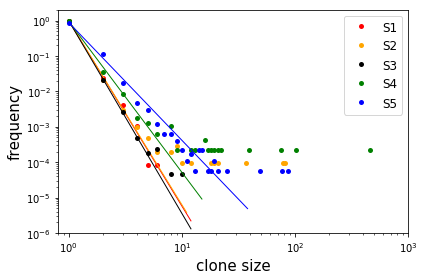

In [38]:
#Plot clone size distribution
#CD4
xmin=1
#Subject 1
xpmax1=((Z(exponent4[0,0],xmin,xmax)/len(TRpCD4_prod_1))**(-1/exponent4[0,0]))*2
xp1=np.arange(1,xpmax1)
plt.plot(CS_cd4_prod_1, CS_cd4_freq_prod_1, 'o', color='red', markeredgecolor='none', markersize=5.0,alpha=1,label='S1')
plt.plot(xp1,powerlawpdf(xp1,exponent4[0,0]),'red',linewidth=1)
#Subject 2
xpmax2=((Z(exponent4[1,0],xmin,xmax)/len(TRpCD4_prod_2))**(-1/exponent4[1,0]))*2
xp2=np.arange(1,xpmax2)
plt.plot(CS_cd4_prod_2, CS_cd4_freq_prod_2, 'o', color='orange', markeredgecolor='none', markersize=5.0,alpha=1,label='S2')
plt.plot(xp2,powerlawpdf(xp2,exponent4[1,0]),'orange',linewidth=1)
#Subject 3
xpmax3=((Z(exponent4[2,0],xmin,xmax)/len(TRpCD4_prod_3))**(-1/exponent4[2,0]))*2
xp3=np.arange(1,xpmax3)
plt.plot(CS_cd4_prod_3, CS_cd4_freq_prod_3, 'o', color='black', markeredgecolor='none', markersize=5.0,alpha=1,label='S3')
plt.plot(xp3,powerlawpdf(xp3,exponent4[2,0]),'black',linewidth=1)
#Subject 4
xpmax4=((Z(exponent4[3,0],xmin,xmax)/len(TRpCD4_prod_4))**(-1/exponent4[3,0]))*2
xp4=np.arange(1,xpmax4)
plt.plot(CS_cd4_prod_4, CS_cd4_freq_prod_4, 'o', color='green', markeredgecolor='none', markersize=5.0,alpha=1,label='S4')
plt.plot(xp4,powerlawpdf(xp4,exponent4[3,0]),'green',linewidth=1)
#Subject 5
xpmax5=((Z(exponent4[4,0],xmin,xmax)/len(TRpCD4_prod_5))**(-1/exponent4[4,0]))*2
xp5=np.arange(1,xpmax5)
plt.plot(CS_cd4_prod_5, CS_cd4_freq_prod_5, 'o', color='blue', markeredgecolor='none', markersize=5.0,alpha=1,label='S5')
plt.plot(xp5,powerlawpdf(xp5,exponent4[4,0]),'blue',linewidth=1)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('clone size',fontsize=15)
plt.ylabel('frequency',fontsize=15)
plt.xlim([10**0-0.2,10**3])
plt.ylim([10**-6,10**0+1])
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('CD4_fitted_powerlaws_paper.png')


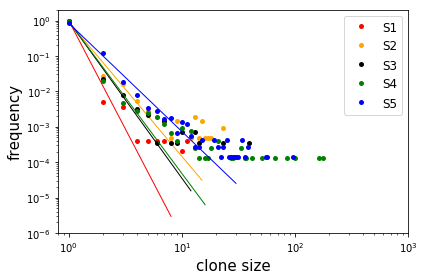

In [39]:
#CD8
xmin=1
#Subject 1
xpmax1=((Z(exponent8[0,0],xmin,xmax)/len(TRpCD8_prod_1))**(-1/exponent8[0,0]))*2
xp1=np.arange(1,xpmax1)
plt.plot(CS_cd8_prod_1, CS_cd8_freq_prod_1, 'o', color='red', markeredgecolor='none', markersize=5.0,alpha=1,label='S1')
plt.plot(xp1,powerlawpdf(xp1,exponent8[0,0]),'red',linewidth=1)
#Subject 2
xpmax2=((Z(exponent8[1,0],xmin,xmax)/len(TRpCD8_prod_2))**(-1/exponent8[1,0]))*2
xp2=np.arange(1,xpmax2)
plt.plot(CS_cd8_prod_2, CS_cd8_freq_prod_2, 'o', color='orange', markeredgecolor='none', markersize=5.0,alpha=1,label='S2')
plt.plot(xp2,powerlawpdf(xp2,exponent8[1,0]),'orange',linewidth=1)
#Subject 3
xpmax3=((Z(exponent8[2,0],xmin,xmax)/len(TRpCD8_prod_3))**(-1/exponent8[2,0]))*2
xp3=np.arange(1,xpmax3)
plt.plot(CS_cd8_prod_3, CS_cd8_freq_prod_3, 'o', color='black', markeredgecolor='none', markersize=5.0,alpha=1,label='S3')
plt.plot(xp3,powerlawpdf(xp3,exponent8[2,0]),'black',linewidth=1)
#Subject 4
xpmax4=((Z(exponent8[3,0],xmin,xmax)/len(TRpCD8_prod_4))**(-1/exponent8[3,0]))*2
xp4=np.arange(1,xpmax4)
plt.plot(CS_cd8_prod_4, CS_cd8_freq_prod_4, 'o', color='green', markeredgecolor='none', markersize=5.0,alpha=1,label='S4')
plt.plot(xp4,powerlawpdf(xp4,exponent8[3,0]),'green',linewidth=1)
#Subject 5
xpmax5=((Z(exponent8[4,0],xmin,xmax)/len(TRpCD8_prod_5))**(-1/exponent4[4,0]))*2
xp5=np.arange(1,xpmax5)
plt.plot(CS_cd8_prod_5, CS_cd8_freq_prod_5, 'o', color='blue', markeredgecolor='none', markersize=5.0,alpha=1,label='S5')
plt.plot(xp5,powerlawpdf(xp5,exponent8[4,0]),'blue',linewidth=1)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('clone size',fontsize=15)
plt.ylabel('frequency',fontsize=15)
plt.xlim([10**0-0.2,10**3])
plt.ylim([10**-6,10**0+1])
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('CD8_fitted_powerlaws_paper.png')

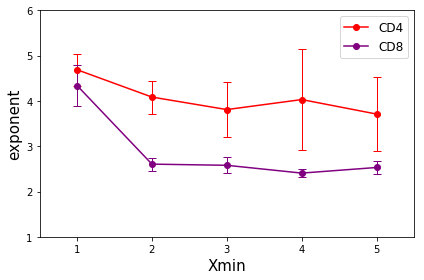

In [44]:
#Plot mean exponents for each Xmin to compare CD4 and CD8.
plt.plot(range(1,6),([mean1_4,mean2_4,mean3_4,mean4_4,mean5_4]),color='red',  marker='o',label='CD4')
plt.errorbar(range(1,6), ([mean1_4,mean2_4,mean3_4,mean4_4,mean5_4]), yerr=([sem1_4,sem2_4,sem3_4,sem4_4,sem5_4]), ls='none', color='red', elinewidth=1, capsize=4)
plt.plot(range(1,6),([mean1_8,mean2_8,mean3_8,mean4_8,mean5_8]),color='purple',  marker='o',label='CD8')
plt.errorbar(range(1,6), ([mean1_8,mean2_8,mean3_8,mean4_8,mean5_8]), yerr=([sem1_8,sem2_8,sem3_8,sem4_8,sem5_8]), ls='none', color='purple', elinewidth=1, capsize=4)
plt.xlabel('Xmin',fontsize=15)
plt.ylabel('exponent',fontsize=15)
plt.ylim(1,6)
plt.xlim(0.5,5.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('mean_powerlaw_exponents.png')

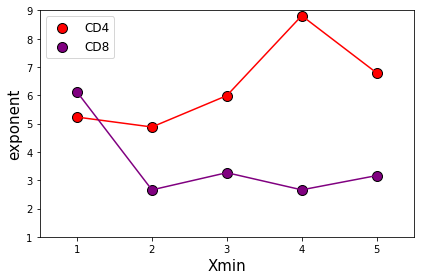

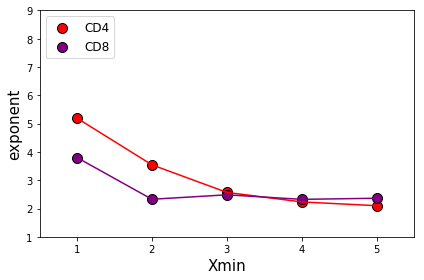

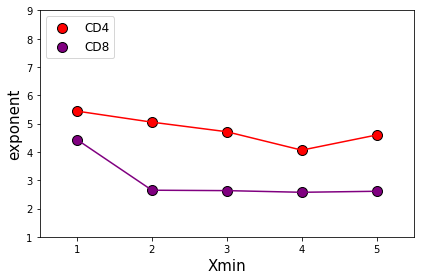

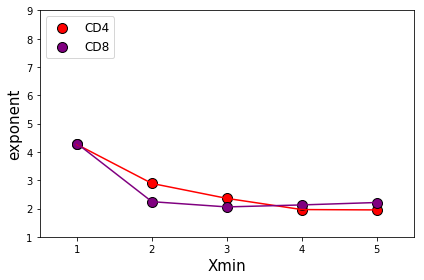

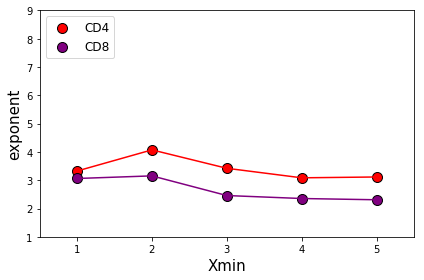

In [57]:
#Plot exponents for each individual subject for each Xmin to compare CD4 and CD8.
for i in range(5):
    plt.figure()
    plt.plot(np.array(range(1,6)),exponent4[i,:],'red')
    plt.scatter(np.array(range(1,6)),exponent4[i,:],marker='o',color='red', edgecolor='black',s=100, label='CD4')
    plt.plot(np.array(range(1,6)),exponent8[i,:],'purple')
    plt.scatter(np.array(range(1,6)),exponent8[i,:],marker='o',color='purple', edgecolor='black',s=100,label='CD8')

    plt.xlabel('Xmin',fontsize=15)
    plt.ylabel('exponent',fontsize=15)
    plt.ylim(1,9)
    plt.xlim(0.5,5.5)
    plt.legend(loc='upper left',fontsize=12)
    plt.tight_layout()

    plt.savefig(('S'+str(i+1)+'_powerlaw_exponents.png'))